<a href="https://colab.research.google.com/github/nisha-s10/Deep-Learning-Lab-AFI524/blob/main/Experiment%204/Experiment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1: Imports & Setup

In [ ]:
import os, shutil, zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# STEP 2: Extract Cats vs Dogs Dataset

In [ ]:
with zipfile.ZipFile("/content/train.zip", "r") as zip_ref:
    zip_ref.extractall("/content/cats_dogs")

# STEP 3: Fix Kaggle Folder Structure

In [ ]:
train_dir = "/content/cats_dogs/train"
os.makedirs(f"{train_dir}/cat", exist_ok=True)
os.makedirs(f"{train_dir}/dog", exist_ok=True)

for f in os.listdir(train_dir):
    fp = os.path.join(train_dir, f)
    if os.path.isdir(fp):
        continue
    if f.startswith("cat"):
        shutil.move(fp, f"{train_dir}/cat/{f}")
    elif f.startswith("dog"):
        shutil.move(fp, f"{train_dir}/dog/{f}")

# STEP 4: Transforms (Preprocessing)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# STEP 5: Load Cats vs Dogs Dataset

In [ ]:
catsdogs_dataset = datasets.ImageFolder(
    root="/content/cats_dogs/train",
    transform=transform
)

train_size = int(0.8 * len(catsdogs_dataset))
test_size = len(catsdogs_dataset) - train_size

cd_train, cd_test = random_split(catsdogs_dataset, [train_size, test_size])

cd_train_loader = DataLoader(cd_train, batch_size=32, shuffle=True)
cd_test_loader   = DataLoader(cd_test, batch_size=32, shuffle=False)

print("Classes:", catsdogs_dataset.classes)

Classes: ['cat', 'dog']


# Show Dataset Images

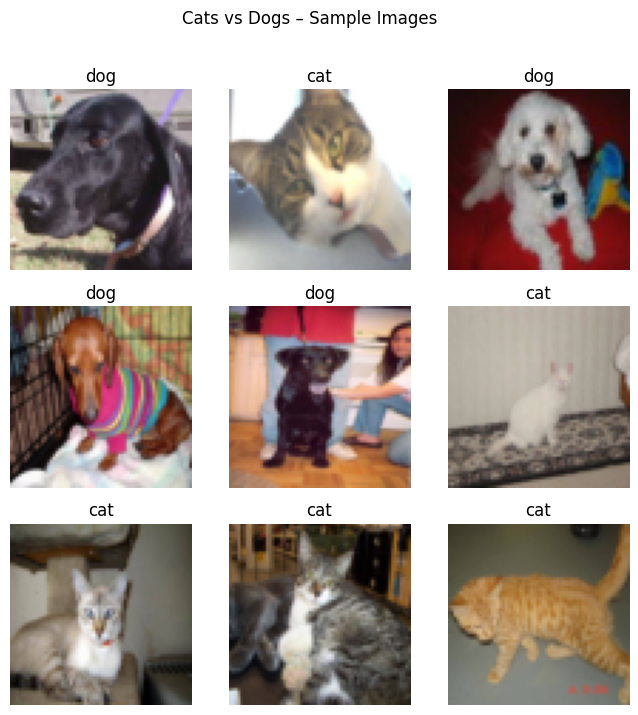

In [ ]:
images, labels = next(iter(cd_train_loader))

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = images[i] * 0.5 + 0.5
    plt.imshow(img.permute(1, 2, 0))
    plt.title(catsdogs_dataset.classes[labels[i]])
    plt.axis("off")
plt.suptitle("Cats vs Dogs – Sample Images")
plt.show()

# STEP 6: Load CIFAR-10 Dataset

In [ ]:
cifar_train = datasets.CIFAR10(
    root="/kaggle/working/cifar10",
    train=True,
    download=True,
    transform=transform
)

cifar_test = datasets.CIFAR10(
    root="/kaggle/working/cifar10",
    train=False,
    download=True,
    transform=transform
)

cifar_train_loader = DataLoader(
    cifar_train,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

cifar_test_loader = DataLoader(
    cifar_test,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

100%|██████████| 170M/170M [00:03<00:00, 47.9MB/s] 


# Show Dataset Images

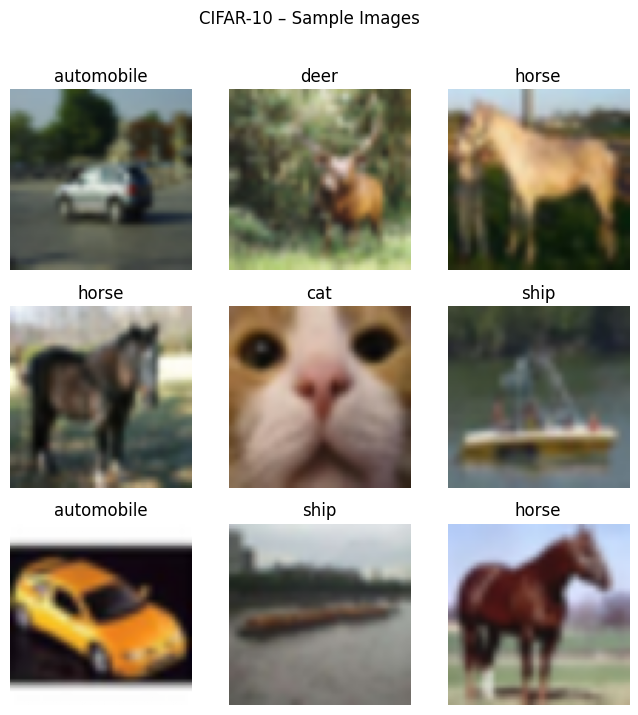

In [ ]:
images, labels = next(iter(cifar_train_loader))

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = images[i] * 0.5 + 0.5
    plt.imshow(img.permute(1, 2, 0))
    plt.title(cifar_train.classes[labels[i]])
    plt.axis("off")
plt.suptitle("CIFAR-10 – Sample Images")
plt.show()

# STEP 7: CNN Model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, activation, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            activation(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),      # 64 → 32

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            activation(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)       # 32 → 16
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),   # 🔥 FIXED
            activation(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# STEP 8: Weight Initialization

In [ ]:
def init_weights(model, init_type):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if init_type == "xavier":
                nn.init.xavier_uniform_(m.weight)
            elif init_type == "kaiming":
                nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")
            else:
                nn.init.normal_(m.weight, 0, 0.01)

# STEP 9: Optimizer Selector

In [ ]:
def get_optimizer(name, model):
    if name == "sgd":
        return optim.SGD(model.parameters(), lr=0.01)
    elif name == "adam":
        return optim.Adam(model.parameters(), lr=0.001)
    else:
        return optim.RMSprop(model.parameters(), lr=0.001)

# STEP 10: Training & Evaluation Loop

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, epochs=3):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_accuracies = []

    model.to(device)

    for epoch in range(epochs):
        # -------- TRAINING --------
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)   # ✅ NOW images exists
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # -------- VALIDATION --------
        model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)   # ✅ again inside loop
                labels = labels.to(device)

                outputs = model(images)
                preds = outputs.argmax(1)

                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_accuracies.append(correct / total)

        print(f"Epoch {epoch+1}: "
              f"Loss={train_losses[-1]:.4f}, "
              f"Acc={val_accuracies[-1]:.4f}")

    return train_losses, val_accuracies

# STEP 11: Run ALL CNN Experiments (3×3×3) for Dogs vs. Cats

In [ ]:
activations = {
    "relu": nn.ReLU,
    "tanh": nn.Tanh,
    "leaky": nn.LeakyReLU
}

inits = ["random", "xavier", "kaiming"]
optimizers = ["sgd", "adam", "rmsprop"]

best_cd_acc = 0
best_cd_config = None

for act in activations:
    for init in inits:
        for opt in optimizers:
            print(f"\nCats vs Dogs → {act}, {init}, {opt}")

            model = SimpleCNN(activations[act], num_classes=2)
            init_weights(model, init)
            model.to(device)

            optimizer = get_optimizer(opt, model)

            train_losses, test_accuracies = train_model(
                model,
                cd_train_loader,
                cd_test_loader,
                optimizer,
                epochs=3
            )

            acc = max(test_accuracies)   # best accuracy during 3 epochs

            if acc > best_cd_acc:
                best_cd_acc = acc
                best_cd_config = (act, init, opt)

print("\nBest configuration found:")
print(f"Activation: {best_cd_config[0]}, Init: {best_cd_config[1]}, Optimizer: {best_cd_config[2]}")
print("Best validation accuracy (3 epochs):", best_cd_acc)



Cats vs Dogs → relu, random, sgd
Epoch 1: Loss=0.6124, Acc=0.7216
Epoch 2: Loss=0.5433, Acc=0.7076
Epoch 3: Loss=0.4948, Acc=0.7516

Cats vs Dogs → relu, random, adam
Epoch 1: Loss=0.6334, Acc=0.7138
Epoch 2: Loss=0.5511, Acc=0.7458
Epoch 3: Loss=0.4886, Acc=0.7822

Cats vs Dogs → relu, random, rmsprop
Epoch 1: Loss=0.7176, Acc=0.6704
Epoch 2: Loss=0.5728, Acc=0.7388
Epoch 3: Loss=0.5019, Acc=0.7872

Cats vs Dogs → relu, xavier, sgd
Epoch 1: Loss=0.6318, Acc=0.7326
Epoch 2: Loss=0.5182, Acc=0.7244
Epoch 3: Loss=0.4682, Acc=0.7764

Cats vs Dogs → relu, xavier, adam
Epoch 1: Loss=0.6833, Acc=0.7258
Epoch 2: Loss=0.5547, Acc=0.7342
Epoch 3: Loss=0.4995, Acc=0.7606

Cats vs Dogs → relu, xavier, rmsprop
Epoch 1: Loss=1.1877, Acc=0.6938
Epoch 2: Loss=0.5770, Acc=0.7622
Epoch 3: Loss=0.5082, Acc=0.7748

Cats vs Dogs → relu, kaiming, sgd
Epoch 1: Loss=0.6315, Acc=0.7300
Epoch 2: Loss=0.5278, Acc=0.7454
Epoch 3: Loss=0.4768, Acc=0.7624

Cats vs Dogs → relu, kaiming, adam
Epoch 1: Loss=0.7061, 

# STEP 12: Save Best CNN Model for Dogs vs. Cats

In [ ]:
# Recreate best model
act, init, opt = best_cd_config

best_cd_model = SimpleCNN(activations[act], num_classes=2)
init_weights(best_cd_model, init)
best_cd_model.to(device)

best_optimizer = get_optimizer(opt, best_cd_model)

# Train best model ONCE
cd_train_losses, cd_test_accuracies = train_model(
    best_cd_model,
    cd_train_loader,
    cd_test_loader,
    best_optimizer,
    epochs=15
)

# Best accuracy during training
best_cd_acc = max(cd_test_accuracies)
best_epoch = cd_test_accuracies.index(best_cd_acc) + 1

print(f"Best CNN → Activation: {best_cd_config[0]}, "
      f"Init: {best_cd_config[1]}, "
      f"Optimizer: {best_cd_config[2]}")

print(f"Final Best CNN Accuracy: {best_cd_acc:.4f} at Epoch {best_epoch}")

# Save model
torch.save(best_cd_model.state_dict(), "best_cnn_catsdogs.pth")
print("Best Cats vs Dogs CNN saved")

Epoch 1: Loss=0.7640, Acc=0.7278
Epoch 2: Loss=0.5600, Acc=0.7450
Epoch 3: Loss=0.5018, Acc=0.7454
Epoch 4: Loss=0.4629, Acc=0.8068
Epoch 5: Loss=0.4112, Acc=0.8172
Epoch 6: Loss=0.3777, Acc=0.8190
Epoch 7: Loss=0.3464, Acc=0.8282
Epoch 8: Loss=0.3111, Acc=0.8120
Epoch 9: Loss=0.2805, Acc=0.8260
Epoch 10: Loss=0.2512, Acc=0.8418
Epoch 11: Loss=0.2100, Acc=0.8290
Epoch 12: Loss=0.1986, Acc=0.8308
Epoch 13: Loss=0.1653, Acc=0.8174
Epoch 14: Loss=0.1554, Acc=0.8284
Epoch 15: Loss=0.1517, Acc=0.8240
Best CNN → Activation: leaky, Init: xavier, Optimizer: adam
Final Best CNN Accuracy: 0.8418 at Epoch 10
Best Cats vs Dogs CNN saved


# True vs Predicted Images (Dogs vs. Cats)

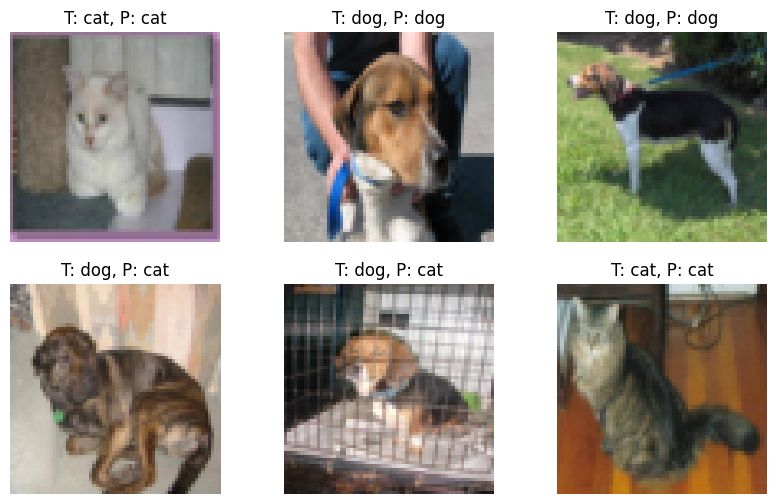

In [ ]:
best_cd_model.eval()
best_cd_model.to(device)

# Get one batch
images, labels = next(iter(cd_test_loader))

# Move images to GPU for inference
images_gpu = images.to(device)
labels_gpu = labels.to(device)

with torch.no_grad():
    outputs = best_cd_model(images_gpu)
    preds = outputs.argmax(1)

# Move everything back to CPU for plotting
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

plt.figure(figsize=(10, 6))

for i in range(6):
    plt.subplot(2, 3, i + 1)

    # Unnormalize image (if Normalize(mean=0.5, std=0.5))
    img = images[i] * 0.5 + 0.5
    img = img.clamp(0, 1)

    plt.imshow(img.permute(1, 2, 0))
    plt.title(
        f"T: {catsdogs_dataset.classes[labels[i]]}, "
        f"P: {catsdogs_dataset.classes[preds[i]]}"
    )
    plt.axis("off")

plt.show()

# Training Loss & Accuracy Curve (Best CNN - Dogs vs. Cats)

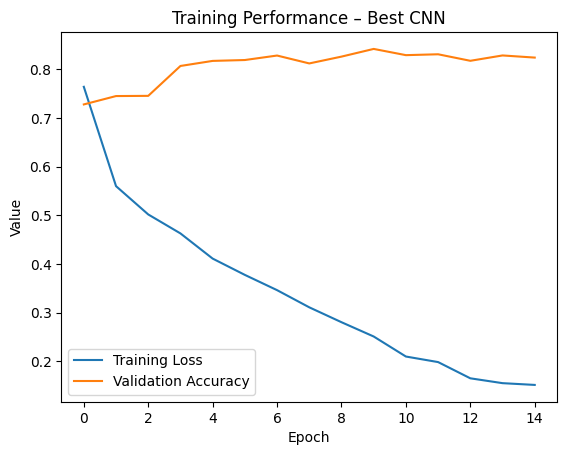

In [ ]:
plt.plot(cd_train_losses, label="Training Loss")
plt.plot(cd_test_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Performance – Best CNN")
plt.legend()
plt.show()

# STEP 13: ResNet-18 (Dogs vs. Cats)

In [ ]:
# Define ResNet-18
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained ResNet-18
weights = ResNet18_Weights.DEFAULT
resnet_cd = resnet18(weights=weights)

# Freeze pretrained layers
for p in resnet_cd.parameters():
    p.requires_grad = False

# Replace final layer for 2 classes
resnet_cd.fc = nn.Linear(resnet_cd.fc.in_features, 2)

# Move model to GPU
resnet_cd.to(device)

# Optimizer for final layer
resnet_optimizer = optim.Adam(resnet_cd.fc.parameters(), lr=0.001)

# Train ResNet-18
resnet_train_losses, resnet_test_accuracies = train_model(
    resnet_cd,
    cd_train_loader,
    cd_test_loader,
    resnet_optimizer,
    epochs=15      # 🔥 match best CNN training
)

# Best accuracy achieved during training
resnet_acc = max(resnet_test_accuracies)
best_epoch = resnet_test_accuracies.index(resnet_acc) + 1

print(f"Best ResNet-18 Accuracy: {resnet_acc:.4f} at Epoch {best_epoch}")

# Save weights
torch.save(resnet_cd.state_dict(), "resnet18_catsdogs.pth")
print("ResNet-18 Cats vs Dogs model saved")

Epoch 1: Loss=0.5295, Acc=0.7704
Epoch 2: Loss=0.5016, Acc=0.7666
Epoch 3: Loss=0.4986, Acc=0.7738
Epoch 4: Loss=0.4980, Acc=0.7694
Epoch 5: Loss=0.5026, Acc=0.7556
Epoch 6: Loss=0.4995, Acc=0.7638
Epoch 7: Loss=0.5012, Acc=0.7730
Epoch 8: Loss=0.5009, Acc=0.7702
Epoch 9: Loss=0.4979, Acc=0.7638
Epoch 10: Loss=0.4954, Acc=0.7690
Epoch 11: Loss=0.4874, Acc=0.7560
Epoch 12: Loss=0.4958, Acc=0.7722
Epoch 13: Loss=0.4939, Acc=0.7676
Epoch 14: Loss=0.4977, Acc=0.7466
Epoch 15: Loss=0.4970, Acc=0.7530
Best ResNet-18 Accuracy: 0.7738 at Epoch 3
ResNet-18 Cats vs Dogs model saved


# Training Loss & Accuracy Curve (ResNet-18 - Dogs vs. Cats)

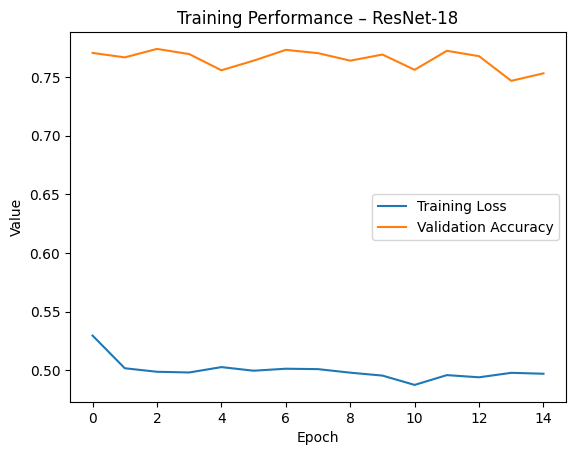

In [ ]:
plt.plot(resnet_train_losses, label="Training Loss")
plt.plot(resnet_test_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Performance – ResNet-18")
plt.legend()
plt.show()

# CNN vs ResNet-18 Comparison (Dogs vs. Cats)

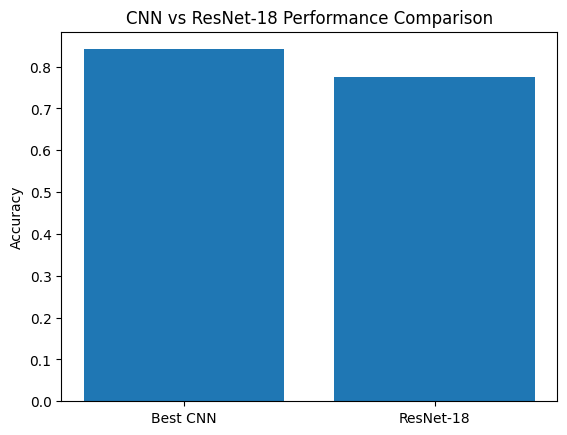

In [ ]:
models = ["Best CNN", "ResNet-18"]
accuracies = [best_cd_acc, resnet_acc]

plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.title("CNN vs ResNet-18 Performance Comparison")
plt.show()

# STEP 14: Run ALL CNN Experiments (3×3×3) for Cifar10

In [ ]:
best_cifar_acc = 0
best_cifar_config = None

for act in activations:
    for init in inits:
        for opt in optimizers:
            print(f"\nCIFAR-10 → {act}, {init}, {opt}")

            model = SimpleCNN(activations[act], num_classes=10)
            init_weights(model, init)
            model.to(device)

            optimizer = get_optimizer(opt, model)

            train_losses, test_accuracies = train_model(
                model,
                cifar_train_loader,
                cifar_test_loader,
                optimizer,
                epochs=3
            )

            acc = max(test_accuracies)   # best accuracy during 3 epochs

            if acc > best_cifar_acc:
                best_cifar_acc = acc
                best_cifar_config = (act, init, opt)

print("\nBest configuration found:")
print(f"Activation: {best_cifar_config[0]}, Init: {best_cifar_config[1]}, Optimizer: {best_cifar_config[2]}")
print("Best validation accuracy (3 epochs):", best_cifar_acc)


CIFAR-10 → relu, random, sgd
Epoch 1: Loss=1.5511, Acc=0.5476
Epoch 2: Loss=1.2403, Acc=0.6210
Epoch 3: Loss=1.0825, Acc=0.6535

CIFAR-10 → relu, random, adam
Epoch 1: Loss=1.6122, Acc=0.5686
Epoch 2: Loss=1.2684, Acc=0.6380
Epoch 3: Loss=1.0977, Acc=0.6586

CIFAR-10 → relu, random, rmsprop
Epoch 1: Loss=1.7633, Acc=0.5164
Epoch 2: Loss=1.4015, Acc=0.5880
Epoch 3: Loss=1.2324, Acc=0.6289

CIFAR-10 → relu, xavier, sgd
Epoch 1: Loss=1.7026, Acc=0.5155
Epoch 2: Loss=1.3729, Acc=0.5865
Epoch 3: Loss=1.2183, Acc=0.6280

CIFAR-10 → relu, xavier, adam
Epoch 1: Loss=2.0638, Acc=0.3753
Epoch 2: Loss=1.7570, Acc=0.5026
Epoch 3: Loss=1.6171, Acc=0.5406

CIFAR-10 → relu, xavier, rmsprop
Epoch 1: Loss=2.3543, Acc=0.3033
Epoch 2: Loss=1.8524, Acc=0.4567
Epoch 3: Loss=1.6750, Acc=0.4933

CIFAR-10 → relu, kaiming, sgd
Epoch 1: Loss=1.6880, Acc=0.4873
Epoch 2: Loss=1.3803, Acc=0.5349
Epoch 3: Loss=1.2352, Acc=0.6053

CIFAR-10 → relu, kaiming, adam
Epoch 1: Loss=2.0674, Acc=0.3703
Epoch 2: Loss=1.7549,

# STEP 15: Save Best Model (Cifar10)

In [ ]:
# Recreate best model
act, init, opt = best_cifar_config

best_cifar_model = SimpleCNN(activations[act], num_classes=10)
init_weights(best_cifar_model, init)
best_cifar_model.to(device)

best_optimizer = get_optimizer(opt, best_cifar_model)

# Train best model ONCE
cifar_train_losses, cifar_test_accuracies = train_model(
    best_cifar_model,
    cifar_train_loader,
    cifar_test_loader,
    best_optimizer,
    epochs=15
)

# Best accuracy during training
best_cifar_acc = max(cifar_test_accuracies)
best_epoch = cifar_test_accuracies.index(best_cifar_acc) + 1

print(f"Best CNN → Activation: {best_cifar_config[0]}, "
      f"Init: {best_cifar_config[1]}, "
      f"Optimizer: {best_cifar_config[2]}")

print(f"Final Best CNN Accuracy: {best_cifar_acc:.4f} at Epoch {best_epoch}")


# Save model
torch.save(best_cifar_model.state_dict(), "best_cnn_cifar10.pth")
print("Best CIFAR-10 CNN saved")

Epoch 1: Loss=1.6173, Acc=0.5677
Epoch 2: Loss=1.2760, Acc=0.6297
Epoch 3: Loss=1.0922, Acc=0.6616
Epoch 4: Loss=0.9689, Acc=0.6703
Epoch 5: Loss=0.8687, Acc=0.6836
Epoch 6: Loss=0.7765, Acc=0.6904
Epoch 7: Loss=0.7087, Acc=0.6878
Epoch 8: Loss=0.6411, Acc=0.6954
Epoch 9: Loss=0.5892, Acc=0.6977
Epoch 10: Loss=0.5443, Acc=0.6950
Epoch 11: Loss=0.4995, Acc=0.6876
Epoch 12: Loss=0.4717, Acc=0.7006
Epoch 13: Loss=0.4419, Acc=0.6948
Epoch 14: Loss=0.4106, Acc=0.6928
Epoch 15: Loss=0.4002, Acc=0.7009
Best CNN → Activation: relu, Init: random, Optimizer: adam
Final Best CNN Accuracy: 0.7009 at Epoch 15
Best CIFAR-10 CNN saved


# True vs Predicted Images (Cifar10)

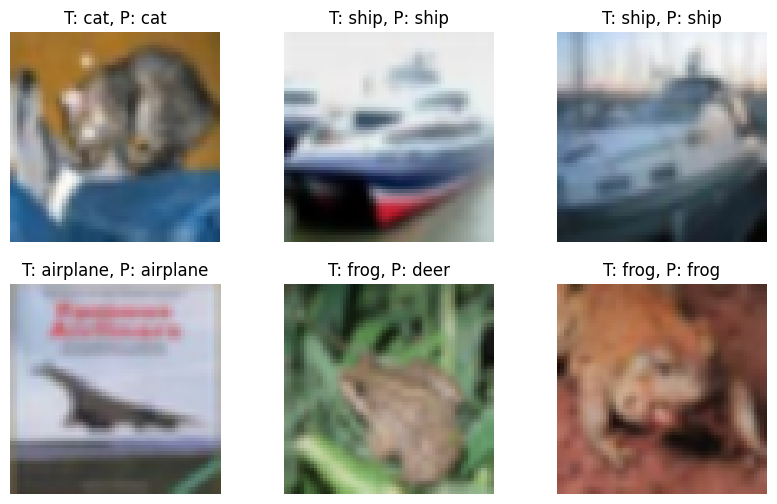

In [ ]:
best_cifar_model.eval()
best_cifar_model.to(device)

# Get one batch
images, labels = next(iter(cifar_test_loader))

# Move images to GPU for inference
images_gpu = images.to(device)
labels_gpu = labels.to(device)

with torch.no_grad():
    outputs = best_cifar_model(images_gpu)
    preds = outputs.argmax(1)

# Move everything back to CPU for plotting
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

plt.figure(figsize=(10, 6))

for i in range(6):
    plt.subplot(2, 3, i + 1)

    # Unnormalize image (if Normalize(mean=0.5, std=0.5))
    img = images[i] * 0.5 + 0.5
    img = img.clamp(0, 1)

    plt.imshow(img.permute(1, 2, 0))
    plt.title(
        f"T: {cifar_test.classes[labels[i]]}, "
        f"P: {cifar_test.classes[preds[i]]}"
    )
    plt.axis("off")

plt.show()

# Training Loss & Accuracy Curve (Best CNN - Cifar10)

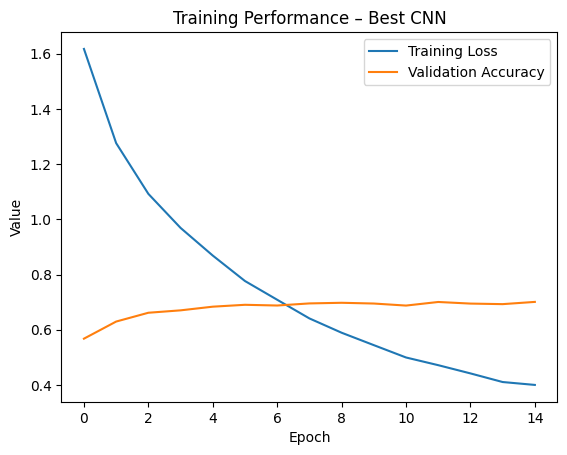

In [ ]:
plt.plot(cifar_train_losses, label="Training Loss")
plt.plot(cifar_test_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Performance – Best CNN")
plt.legend()
plt.show()

# STEP 16: ResNet-18 (Cifar10)

In [ ]:
# Define ResNet-18
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained ResNet-18
weights = ResNet18_Weights.DEFAULT
resnet_cifar = resnet18(weights=weights)

# Freeze pretrained layers
for p in resnet_cifar.parameters():
    p.requires_grad = False

# Replace final layer for 10 classes
resnet_cifar.fc = nn.Linear(resnet_cifar.fc.in_features, 10)

# Move model to GPU
resnet_cifar.to(device)

# Optimizer for final layer
resnet_optimizer = optim.Adam(resnet_cifar.fc.parameters(), lr=0.001)

# Train ResNet-18
resnet_train_losses, resnet_test_accuracies = train_model(
    resnet_cifar,
    cifar_train_loader,
    cifar_test_loader,
    resnet_optimizer,
    epochs=15      # 🔥 match best CNN training
)

# Best accuracy achieved during training
resnet_acc = max(resnet_test_accuracies)
best_epoch = resnet_test_accuracies.index(resnet_acc) + 1

print(f"Best ResNet-18 Accuracy: {resnet_acc:.4f} at Epoch {best_epoch}")

# Save weights
torch.save(resnet_cifar.state_dict(), "resnet18_cifar10.pth")
print("ResNet-18 Cifar 10 saved")

Epoch 1: Loss=1.2413, Acc=0.6340
Epoch 2: Loss=1.1221, Acc=0.6410
Epoch 3: Loss=1.1094, Acc=0.6274
Epoch 4: Loss=1.1014, Acc=0.6409
Epoch 5: Loss=1.1004, Acc=0.6435
Epoch 6: Loss=1.1019, Acc=0.6390
Epoch 7: Loss=1.0987, Acc=0.6381
Epoch 8: Loss=1.1025, Acc=0.6494
Epoch 9: Loss=1.0942, Acc=0.6467
Epoch 10: Loss=1.0962, Acc=0.6322
Epoch 11: Loss=1.1024, Acc=0.6469
Epoch 12: Loss=1.1015, Acc=0.6450
Epoch 13: Loss=1.0973, Acc=0.6341
Epoch 14: Loss=1.0960, Acc=0.6394
Epoch 15: Loss=1.0934, Acc=0.6406
Best ResNet-18 Accuracy: 0.6494 at Epoch 8
ResNet-18 Cifar 10 saved


# Training Loss & Accuracy Curve (ResNet-18 - Cifar10)

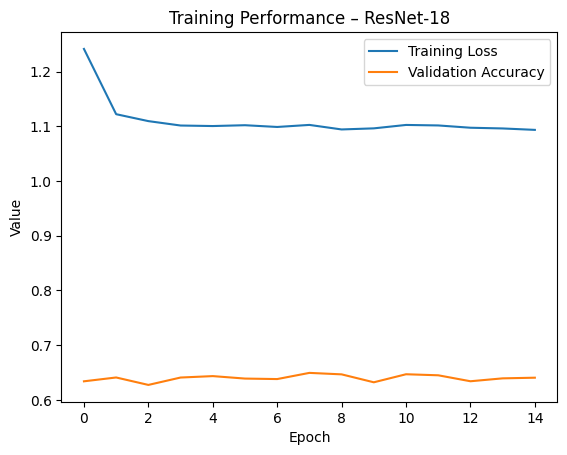

In [ ]:
plt.plot(resnet_train_losses, label="Training Loss")
plt.plot(resnet_test_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Performance – ResNet-18")
plt.legend()
plt.show()

# CNN vs ResNet-18 Comparison (Cifar10)

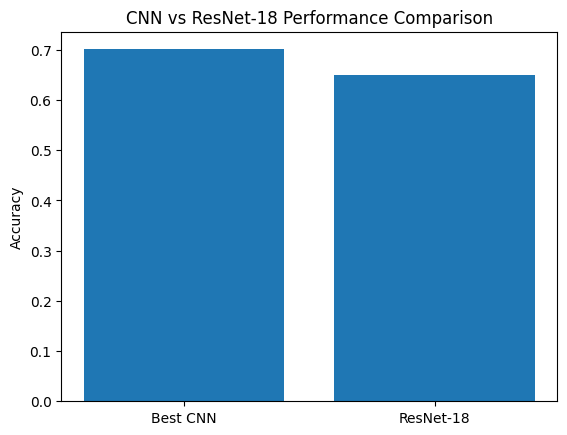

In [ ]:
models = ["Best CNN", "ResNet-18"]
accuracies = [best_cifar_acc, resnet_acc]

plt.bar(models, accuracies)
plt.ylabel("Accuracy")
plt.title("CNN vs ResNet-18 Performance Comparison")
plt.show()